In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
import copy


In [2]:
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_and_ztrans\Hao_PBMC_ztrans_Harmony.h5ad")
adata = sc.read_h5ad("/home/jovyan/work/Research_datasets/PBMC_Hao/GSE164378_Hao/Harmony_and_ztrans/Hao_PBMC_ztrans_Harmony.h5ad")
adata.shape  # row is cells, column is gene

(161764, 33538)

In [3]:
type(adata.X)

numpy.ndarray

In [4]:
# view adata.X
rows, cols = adata.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata.X[row, col]}')
    i += 1


Row 0, Column 0, Value -0.0024863318540155888
Row 0, Column 2, Value -0.0035134670324623585
Row 0, Column 3, Value -0.049054428935050964
Row 0, Column 4, Value -0.01666545867919922
Row 0, Column 6, Value -0.02288634330034256
Row 0, Column 11, Value -0.010429894551634789
Row 0, Column 12, Value 3.152909755706787
Row 0, Column 13, Value -0.021930525079369545
Row 0, Column 14, Value -0.1481582671403885
Row 0, Column 15, Value -0.11470266431570053
Row 0, Column 16, Value -0.002486331621184945
Row 0, Column 17, Value -0.020627329126000404
Row 0, Column 18, Value -0.006265848875045776
Row 0, Column 19, Value -0.002486331621184945
Row 0, Column 20, Value -0.025506339967250824
Row 0, Column 21, Value -0.46497780084609985
Row 0, Column 22, Value -0.12491539120674133
Row 0, Column 23, Value -0.07090125232934952
Row 0, Column 24, Value -0.01251706201583147
Row 0, Column 25, Value -0.03329896181821823


In [5]:
# sparse CSR matrix
# num_nonzero = adata.X.getnnz(axis=1)
# num_nonzero[:10]
# dense matrix
num_nonzero = np.count_nonzero(adata.X, axis=1)  # number of nonzeros for each row
num_nonzero[:10]

array([27504, 27504, 27504, 27504, 27504, 27504, 27504, 27504, 27504,
       27504])

In [6]:
# Check for columns with all zeros
all_zero_cols = np.all(adata.X == 0, axis=0)
zero_cols_count = np.sum(all_zero_cols)
print('No. of columns with all zeros:', zero_cols_count)  # 6034

# Remove columns with all zeros
adata = adata[:, ~all_zero_cols]
print('New shape of adata.X:', adata.X.shape)
print('New shape of adata.var:', adata.var.shape)

No. of columns with all zeros: 6034
New shape of adata.X: (161764, 27504)
New shape of adata.var: (27504, 2)


In [7]:
# All level 2 celltypes
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(" ", "_")
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(" ", "_")
adata.obs['celltype.l3'] = adata.obs['celltype.l3'].str.replace(" ", "_")
types = np.unique(adata.obs['celltype.l2']).tolist()
print(types)
# cell count in each celltype
adata.obs['celltype.l2'].value_counts()

/tmp/ipykernel_1190/1468695212.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(" ", "_")


['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


celltype.l2
CD14_Mono            42690
CD4_Naive            17479
NK                   17173
CD4_TCM              14889
CD8_TEM              11727
CD8_Naive            10768
B_naive               7718
CD16_Mono             6320
CD4_TEM               4282
gdT                   3649
B_memory              3285
CD8_TCM               2883
MAIT                  2784
Treg                  2507
cDC2                  2501
B_intermediate        2431
Platelet              2293
CD4_CTL               1736
NK_CD56bright          943
pDC                    861
Doublet                605
NK_Proliferating       548
Plasmablast            366
dnT                    356
HSPC                   329
cDC1                   151
ILC                    132
CD4_Proliferating      108
CD8_Proliferating       91
Eryth                   83
ASDC                    76
Name: count, dtype: int64

In [8]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## UMAP with stored embedding in Hao_PBMC_scaled_Harmony.h5ad

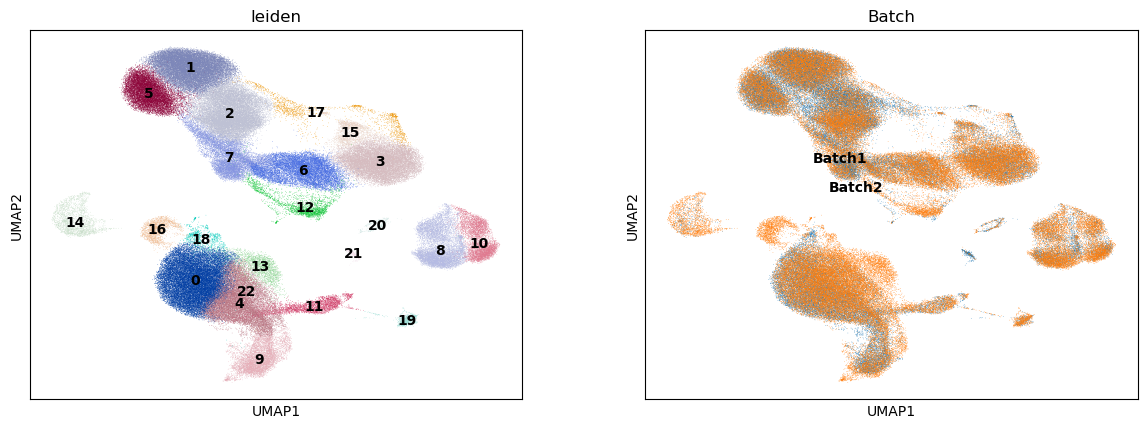

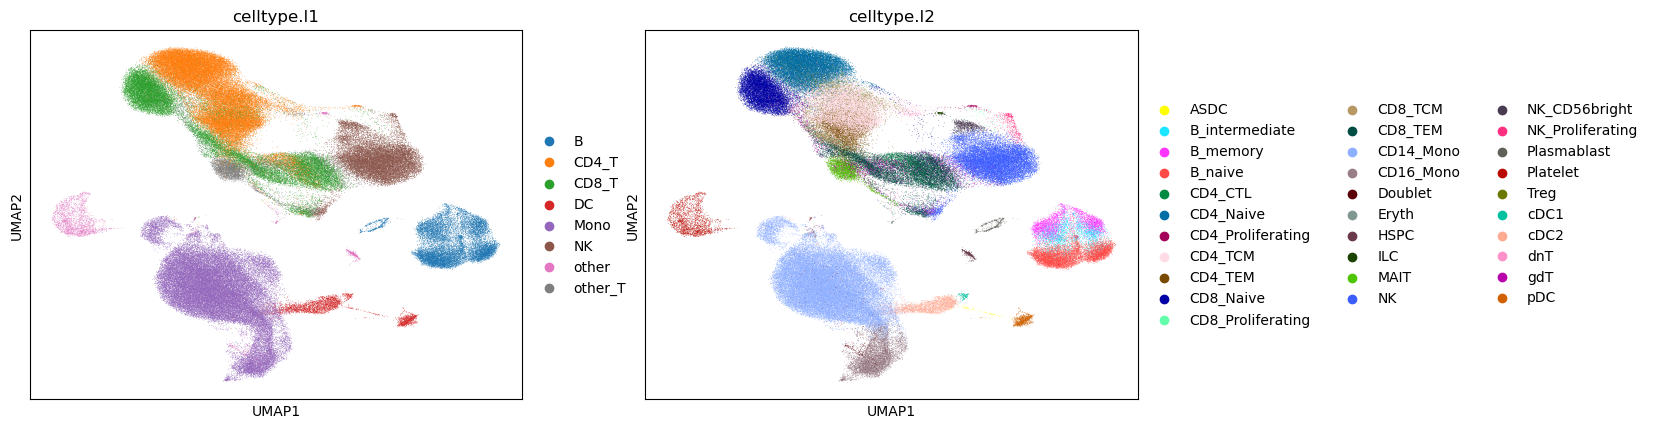

In [9]:
sc.pl.umap(adata, color=['leiden', 'Batch'], legend_loc="on data")
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2'], legend_loc="right margin")

## Representative cells
Select top clustering coefficient cells in each cell type <br>
According to the inverse relationshiop between "celltype cell count" and "Percentage" <br>
Detailed in Excel file <br>

In [10]:
umap_adja_matrix = adata.obsp['connectivities']  # derived from sc.pp.neighbors()
umap_adja_matrix

<161764x161764 sparse matrix of type '<class 'numpy.float32'>'
	with 3703680 stored elements in Compressed Sparse Row format>

In [11]:
# Clustering coefficient
import networkx as nx

G = nx.from_scipy_sparse_array(umap_adja_matrix)
print(G)

clustering_coeff = nx.clustering(G)
print(len(clustering_coeff))

Graph with 161764 nodes and 1851840 edges
161764


In [12]:
# Get the first 10 keys and values of the dictionary
first_10_items = list(clustering_coeff.items())[:10]

# Print the first 10 keys and values
for key, value in first_10_items:
    print(f"Key: {key}, Value: {value}")

# Keys are cell index, values are the corresponding clustering coefficient

Key: 0, Value: 0.14619883040935672
Key: 1, Value: 0.1323529411764706
Key: 2, Value: 0.17582417582417584
Key: 3, Value: 0.09523809523809523
Key: 4, Value: 0.11578947368421053
Key: 5, Value: 0.1830065359477124
Key: 6, Value: 0.13333333333333333
Key: 7, Value: 0.15833333333333333
Key: 8, Value: 0.14705882352941177
Key: 9, Value: 0.13333333333333333


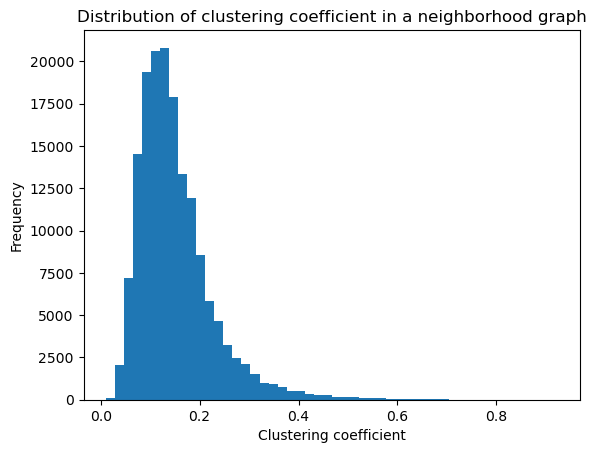

In [13]:
# Plot the distribution of clustering coefficients
import matplotlib.pyplot as plt
coefs = list(clustering_coeff.values())
plt.title('Distribution of clustering coefficient in a neighborhood graph')
plt.hist(coefs, bins=50)
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.show()


In [14]:
# selection criteria
inv_percentage = pd.read_csv('L2_log(count)_inv_percentage.csv', index_col=0)
inv_percentage

,Original count,log10(count),Percentage,Selected count
CD14_Mono,42690,4.630326,0.200000,8538
CD4_Naive,17479,4.242517,0.312837,5469
NK,17173,4.234846,0.315069,5411
CD4_TCM,14889,4.172866,0.333103,4960
CD8_TEM,11727,4.069187,0.363269,4261
CD8_Naive,10768,4.032135,0.374050,4028
B_naive,7718,3.887505,0.416132,3212
CD16_Mono,6320,3.800717,0.441384,2790
CD4_TEM,4282,3.631647,0.490576,2101
gdT,3649,3.562174,0.510790,1864


In [15]:
import math
# Select top percentage clustering coefficient cells in each cell type
alltype_selected = dict()

for celltype in types:
    print('====================')
    # get percentage
    percentage = inv_percentage.loc[celltype, 'Percentage']
    print(celltype, percentage)

    # select cells from one celltype
    celltype_idx = np.where(adata.obs['celltype.l2'] == celltype)[0]
    celltype_coeff = {node_idx: clustering_coeff[node_idx] for node_idx in celltype_idx}
    
    top_count = math.ceil(len(celltype_coeff) * percentage)
    print('top count', top_count)
    top_indices = sorted(celltype_coeff, key=celltype_coeff.get, reverse=True)[:top_count]  # sort celltype_coeff by value (descending)
    # print(top_indices)
    celltype_selected = {node_idx: celltype_coeff[node_idx] for node_idx in top_indices}
    # print(celltype_selected)
    alltype_selected.update(celltype_selected)
    print(celltype, len(celltype_selected))


ASDC 1.0
top count 76
ASDC 76
B_intermediate 0.562112532
top count 1367
B_intermediate 1367
B_memory 0.524069305
top count 1722
B_memory 1722
B_naive 0.416131802
top count 3212
B_naive 3212
CD14_Mono 0.2
top count 8538
CD14_Mono 8538
CD16_Mono 0.441383608
top count 2790
CD16_Mono 2790
CD4_CTL 0.604661234
top count 1050
CD4_CTL 1050
CD4_Naive 0.312837331
top count 5469
CD4_Naive 5469
CD4_Proliferating 0.955596446
top count 104
CD4_Proliferating 104
CD4_TCM 0.333103047
top count 4960
CD4_TCM 4960
CD4_TEM 0.490576448
top count 2101
CD4_TEM 2101
CD8_Naive 0.374050082
top count 4028
CD8_Naive 4028
CD8_Proliferating 0.977238787
top count 89
CD8_Proliferating 89
CD8_TCM 0.540564078
top count 1559
CD8_TCM 1559
CD8_TEM 0.363269443
top count 4261
CD8_TEM 4261
Doublet 0.737861381
top count 447
Doublet 447
Eryth 0.988866536
top count 83
Eryth 83
HSPC 0.814837782
top count 269
HSPC 269
ILC 0.930239173
top count 123
ILC 123
MAIT 0.544979525
top count 1518
MAIT 1518
NK 0.315069119
top count 5411
NK 5

In [16]:
len(alltype_selected)

57515

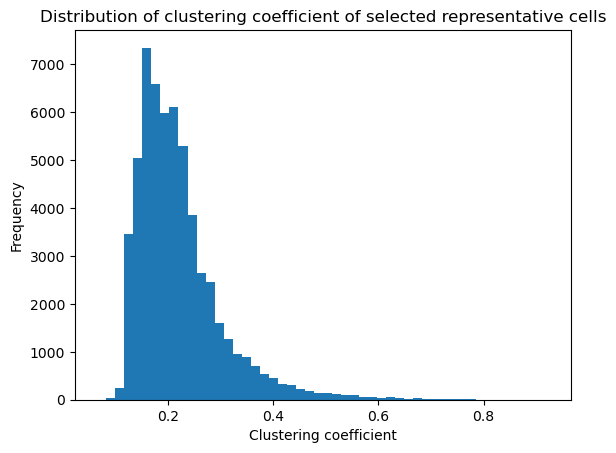

In [17]:
# Plot the distribution of clustering coefficients of selected representative cells
import matplotlib.pyplot as plt
coefs = list(alltype_selected.values())
plt.title('Distribution of clustering coefficient of selected representative cells')
plt.hist(coefs, bins=50)
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.show()


In [18]:
# add column to adata.obs
is_representative = ['Yes' if cell in alltype_selected.keys() else 'No' for cell in clustering_coeff.keys()]
is_representative = np.array(is_representative)

# Add is_representative (Yes or No) to data.obs
adata.obs['is_representative'] = is_representative
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4,No
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2,No
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5,Yes
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3,No
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5,No


In [19]:
sum(adata.obs['is_representative'] == 'Yes')

57515

In [20]:
# Add a column: Cluster_representative
# 在 representative cell 中，加上 cluster
clus_rep = []
for i in range(adata.shape[0]):
    if adata.obs['is_representative'][i] == 'Yes':
        # Yes_cluster_name
        clus_rep.append(adata.obs['is_representative'][i] + '_' + adata.obs['celltype.l2'][i])
    else:
        # No
        clus_rep.append(adata.obs['is_representative'][i])

adata.obs['cluster_representative'] = clus_rep

In [21]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4,No,No
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2,No,No
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5,Yes,Yes_CD8_Naive
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3,No,No
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5,No,No


## Plot representative cell UMAP

In [22]:
### Get palette
# Get cell counts for each cell type
l1_cell_counts = adata.obs['celltype.l1'].value_counts()  # in value order 
l2_cell_counts = adata.obs['celltype.l2'].value_counts()

# Get colors from sc.pl.umap() plot
l1_colors = adata.uns['celltype.l1_colors']  # in celltype alphabet order
l2_colors = adata.uns['celltype.l2_colors']
# map cell type names to colors
l1_cmap = dict(zip(l1_cell_counts.index.sort_values(), l1_colors))  # in alphabet order
l2_cmap = dict(zip(l2_cell_counts.index.sort_values(), l2_colors))

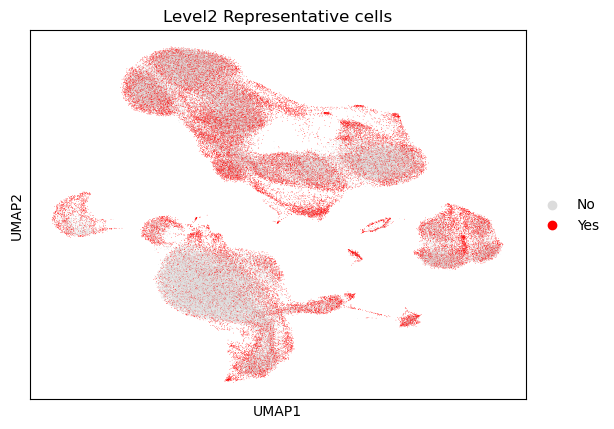

In [23]:
# Plot Yes/No representative cells
sc.pl.umap(adata, color='is_representative', title='Level2 Representative cells', palette=['#dcdcdc', 'red'])

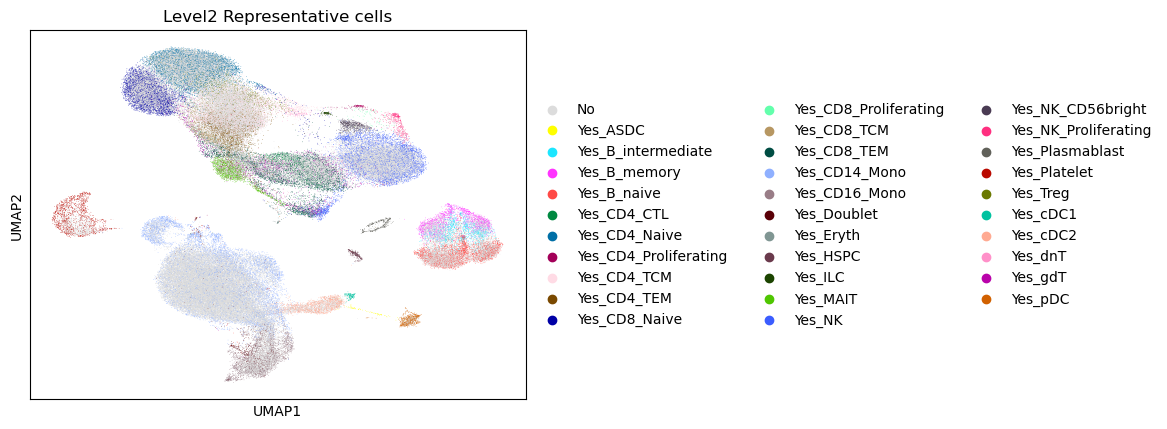

In [24]:
# Also differentiating representative cells from different cell types
sc.pl.umap(adata, color='cluster_representative', title='Level2 Representative cells', palette=['#dcdcdc']+l2_colors.tolist())

## Export representative cells adata

In [29]:
# os.chdir(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_and_ztrans")
os.chdir('/home/jovyan/work/Research_datasets/PBMC_Hao/GSE164378_Hao/Harmony_and_ztrans/a')

In [27]:
adata_rep_cells = adata[adata.obs['is_representative'] == 'Yes']
adata_rep_cells.shape

(57515, 27504)

In [28]:
adata_rep_cells.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5,Yes,Yes_CD8_Naive
L1_AAACCCACATCAGTCA,CD8_T,CD8_TEM,CD8_TEM_1,Batch1,P3,2,L1,G1,5297,212,4332,1633,6,Yes,Yes_CD8_TEM
L1_AAACCCATCCACACCT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P3,2,L1,S,4557,209,3401,1200,5,Yes,Yes_CD8_Naive
L1_AAACGAACAATGAGCG,CD4_T,CD4_TCM,CD4_TCM_2,Batch1,P1,7,L1,G1,5465,211,7379,2315,17,Yes,Yes_CD4_TCM
L1_AAACGAACAGCTACTA,NK,NK,NK_2,Batch1,P4,7,L1,G1,3161,211,1538,822,12,Yes,Yes_NK


In [31]:
adata_rep_cells.write_h5ad('Hao_L2_repcells_loginv_Harmony_ztrans.h5ad')

In [32]:
np.unique(adata_rep_cells.obs['celltype.l2']).tolist()

['ASDC',
 'B_intermediate',
 'B_memory',
 'B_naive',
 'CD14_Mono',
 'CD16_Mono',
 'CD4_CTL',
 'CD4_Naive',
 'CD4_Proliferating',
 'CD4_TCM',
 'CD4_TEM',
 'CD8_Naive',
 'CD8_Proliferating',
 'CD8_TCM',
 'CD8_TEM',
 'Doublet',
 'Eryth',
 'HSPC',
 'ILC',
 'MAIT',
 'NK',
 'NK_CD56bright',
 'NK_Proliferating',
 'Plasmablast',
 'Platelet',
 'Treg',
 'cDC1',
 'cDC2',
 'dnT',
 'gdT',
 'pDC']